In [67]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [ ]:
def generate_seq(init_cond, length):
    seq = init_cond.copy()
    for _ in range(length - len(init_cond)):
        x = seq[-10:]
        next_val = (
            0.5 * math.sin(2*x[-1]) +
            0.2 * math.tanh(x[-3] * x[-2]) +
            0.6 * math.cos(x[-5] + x[-6]) -
            0.2 * (x[-7] ** 2) +
            0.05 * math.log(abs(x[-10]) + 1e-3)+
            0.005 * np.random.randn()
        )
        seq.append(next_val)
    return seq

def create_dataset(num_sequences=1000):
    sequences = []
    for _ in range(num_sequences):
        init_cond = np.random.uniform(-1, 1, 10).tolist()
        length = np.random.randint(50, 100)
        sequences.append(generate_seq(init_cond, length))
    return sequences

def prepare_data(sequences, min_len=10, max_len=30):
    X, y = [], []
    for seq in sequences:
        seq_len = np.random.randint(min_len, min(max_len, len(seq)-1))
        for i in range(len(seq) - seq_len):
            X.append(seq[i:i+seq_len])
            y.append(seq[i+seq_len])
    return np.array(X, dtype=object), np.array(y)

sequences = create_dataset()
X, y = prepare_data(sequences)

max_len = max(len(x) for x in X)
X_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X, maxlen=max_len, padding='post', dtype='float32'
)[..., np.newaxis]

In [69]:
# def build_model():
#     inp = Input(shape=(None, 1))
#     x = LSTM(64, return_sequences=True)(inp)
#     x = LSTM(32)(x)
#     out = Dense(1)(x)
#     return Model(inp, out)
# model1 = build_model()
# model1.compile(optimizer='adam', loss='mse')
# model1.fit(X_padded, y, epochs=20, batch_size=32)
model1 = tf.keras.models.load_model('model1.keras')

c:\Users\mymri\anaconda3\envs\tf218\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [71]:
# inp = Input(shape=(None, 1))
# x = LSTM(64, return_sequences=True)(inp)
# x = LSTM(32, return_sequences=True)(x)
# x = LSTM(32)(x)
# out = Dense(1)(x)
# model3 = Model(inp, out)
# model3.compile(optimizer='adam', loss='mse')
# model3.fit(X_padded, y, epochs=20, batch_size=32)
model3 = tf.keras.models.load_model('model3.keras')


In [72]:
# inp = Input(shape=(None, 1))
# x = LSTM(64, return_sequences=True)(inp)
# x = LSTM(32, return_sequences=True)(x)
# x = LSTM(32, return_sequences=True)(x)
# x = LSTM(32)(x)
# out = Dense(1)(x)
# model4 = Model(inp, out)
# model4.compile(optimizer='adam', loss='mse')
# model4.fit(X_padded, y, epochs=20, batch_size=32)
model4 = tf.keras.models.load_model('model4.keras')

In [73]:
# inp = Input(shape=(None, 1))
# x = LSTM(64)(inp)
# out = Dense(1)(x)
# model2 = Model(inp, out)
# model2.compile(optimizer='adam', loss='mse')
# model2.fit(X_padded, y, epochs=20, batch_size=32)
model2 = tf.keras.models.load_model('model2.keras')

In [74]:
def draw(model, test_init):
    import matplotlib.pyplot as plt

    true_sequence = generate_seq(test_init, 200)
    test_seq = test_init.copy()
    errors = []

    for i in range(200):
        input_len = min(20, len(test_seq))
        x = np.array(test_seq[-input_len:])[np.newaxis, ..., np.newaxis]

        pred = model.predict(x, verbose=0)[0,0]
        test_seq.append(pred)

        if i + 10 < len(true_sequence):
            true_val = true_sequence[10 + i]
            error = abs(pred - true_val)
            errors.append(error)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(true_sequence, label='Истинная последовательность')
    plt.plot(range(10, 200), test_seq[10:200], label='Предсказанная последовательность')
    plt.axvline(x=10, color='r', linestyle='--', label='Начало прогноза')
    plt.title('Сравнение истинной и предсказанной последовательностей')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(errors, color='red', label='Ошибка предсказания')
    plt.title('График ошибок предсказания')
    plt.xlabel('Шаг предсказания')
    plt.ylabel('Абсолютная ошибка')
    plt.legend()

    plt.tight_layout()
    plt.show()
#draw(model2, test_init)

In [95]:
test_init = np.random.uniform(-1, 1, 10).tolist()

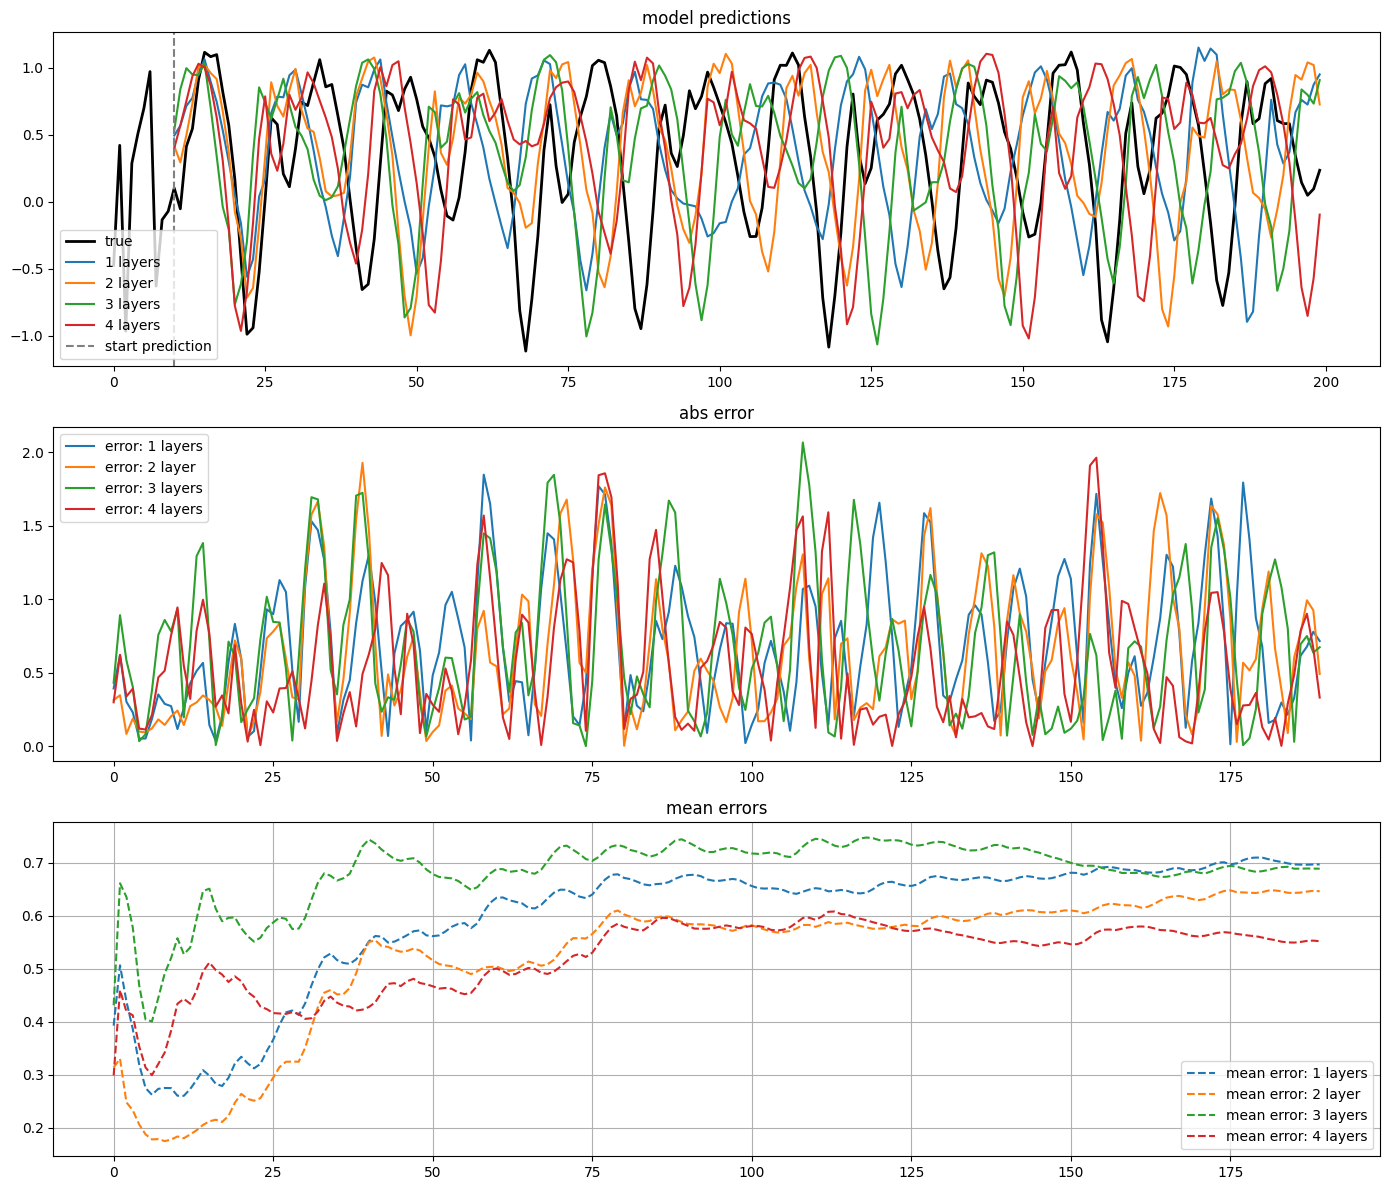

mean error for 1:  0.6970467852202618
mean error for 2:  0.6464739819894831
mean error for 3:  0.6889937777789764
mean error for 4:  0.552143732839629


In [102]:
def draw_multiple_models(models, model_names, test_init):
    true_sequence = generate_seq(test_init, 200)

    all_predictions = []
    all_errors = []

    for model in models:
        test_seq = test_init.copy()
        predictions = []
        errors = []
        mean_errors = []

        for i in range(200):
            input_len = min(15, len(test_seq))
            x = np.array(test_seq[-input_len:])[np.newaxis, ..., np.newaxis]

            pred = model.predict(x, verbose=0)[0, 0]
            test_seq.append(pred)
            predictions.append(pred)

            if i + 10 < len(true_sequence):
                true_val = true_sequence[10 + i]
                error = abs(pred - true_val)
                errors.append(error)
                mean_errors.append(np.mean(errors))

        all_predictions.append(predictions)
        all_errors.append((errors, mean_errors))

    plt.figure(figsize=(14, 12))

    plt.subplot(3, 1, 1)
    plt.plot(true_sequence, label='true', color='black', linewidth=2)

    for i, preds in enumerate(all_predictions):
        plt.plot(range(10, 200), preds[:190], label=f'{model_names[i]}')

    plt.axvline(x=10, color='gray', linestyle='--', label='start prediction')
    plt.title('model predictions')
    plt.legend()

    plt.subplot(3, 1, 2)
    for i, (errors, _) in enumerate(all_errors):
        plt.plot(errors, label=f'error: {model_names[i]}')

    plt.title('abs error')
    plt.legend()

    plt.subplot(3, 1, 3)
    for i, (_, means) in enumerate(all_errors):
        plt.plot(means, label=f'mean error: {model_names[i]}', linestyle='--')

    plt.title('mean errors')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return all_errors

models = [model2, model1, model3, model4]
names = ['1 layers', '2 layer', '3 layers', '4 layers']

allerrors = draw_multiple_models(models, names, test_init)
print(f"mean error for 1:  {allerrors[0][1][-1]}")
print(f"mean error for 2:  {allerrors[1][1][-1]}")
print(f"mean error for 3:  {allerrors[2][1][-1]}")
print(f"mean error for 4:  {allerrors[3][1][-1]}")


In [97]:
def build_stateful_from_stateless(stateless_model, batch_size=1):
    inp = Input(batch_shape=(batch_size, None, 1))

    x = inp
    for layer in stateless_model.layers[1:]:
        config = layer.get_config()
        if 'stateful' in config:
            config['stateful'] = True
        LayerClass = type(layer)
        x = LayerClass.from_config(config)(x)

    stateful_model = Model(inp, x)

    for layer_stateless, layer_stateful in zip(stateless_model.layers[1:], stateful_model.layers[1:]):
        layer_stateful.set_weights(layer_stateless.get_weights())
    
    return stateful_model

def reset_states(stateful_model):
    for layer in stateful_model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

In [98]:
def predict_stateless(model, init_seq, steps, window_size=15):
    seq = init_seq.copy()
    predictions = []
    for i in range(steps):
        input_len = min(window_size, len(seq))
        x = np.array(seq[-input_len:])[np.newaxis, ..., np.newaxis]
        pred = model.predict(x, verbose=0)[0, 0]
        seq.append(pred)
        predictions.append(pred)
    return predictions

def predict_stateful(stateful_model, init_seq, steps):
    reset_states(stateful_model)
    warmup_seq = np.array(init_seq, dtype='float32')[np.newaxis, ..., np.newaxis]
    _ = stateful_model.predict(warmup_seq, verbose=0)
    predictions = []
    last_value = init_seq[-1]
    for _ in range(steps):
        x = np.array([[[last_value]]], dtype='float32')
        pred = stateful_model.predict(x, verbose=0)[0,0]
        predictions.append(pred)
        last_value = pred
    return predictions

In [114]:
def draw_stateless_vs_stateful(stateless_model, stateful_model, test_init):
    true_sequence = generate_seq(test_init, 200)
    steps = 190
    
    preds_stateless = predict_stateless(stateless_model, test_init, steps)
    preds_stateful = predict_stateful(stateful_model, test_init, steps)
    
    errors_stateless = [abs(p - t) for p, t in zip(preds_stateless, true_sequence[10:])]
    errors_stateful = [abs(p - t) for p, t in zip(preds_stateful, true_sequence[10:])]

    def moving_avg(arr, window=5):
        return np.convolve(arr, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(14, 10))

    plt.subplot(2,1,1)
    plt.plot(true_sequence, label='true', color='black', linewidth=2)
    plt.plot(range(10, 200), preds_stateless, label='Stateless prediction')
    plt.plot(range(10, 200), preds_stateful, label='Stateful prediction')
    plt.axvline(x=10, color='gray', linestyle='--', label='start prediction')
    plt.title('stateless vs stateful predictions')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(moving_avg(errors_stateless), label='mean errors stateless')
    plt.plot(moving_avg(errors_stateful), label='mean errors stateful')
    plt.title('mean errors')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"mean error stateless: {np.mean(errors_stateless):.5f}")
    print(f"mean error stateful: {np.mean(errors_stateful):.5f}")


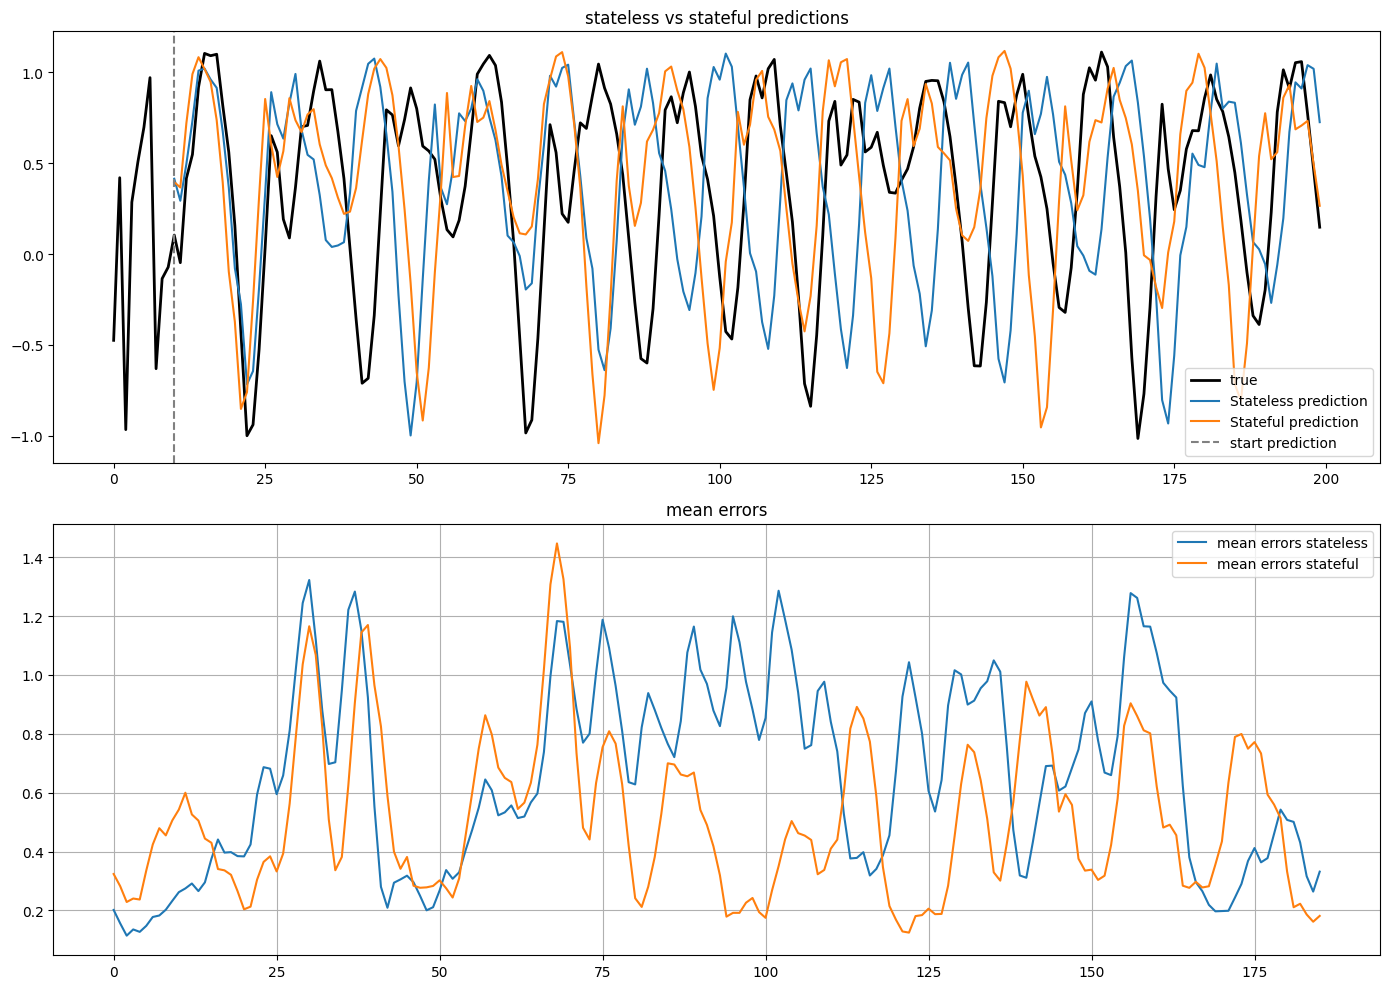

mean error stateless: 0.65706
mean error stateful: 0.51118


In [115]:
stateful_model1 = build_stateful_from_stateless(model1, batch_size=1)
reset_states(stateful_model1)
draw_stateless_vs_stateful(model1, stateful_model1, test_init)

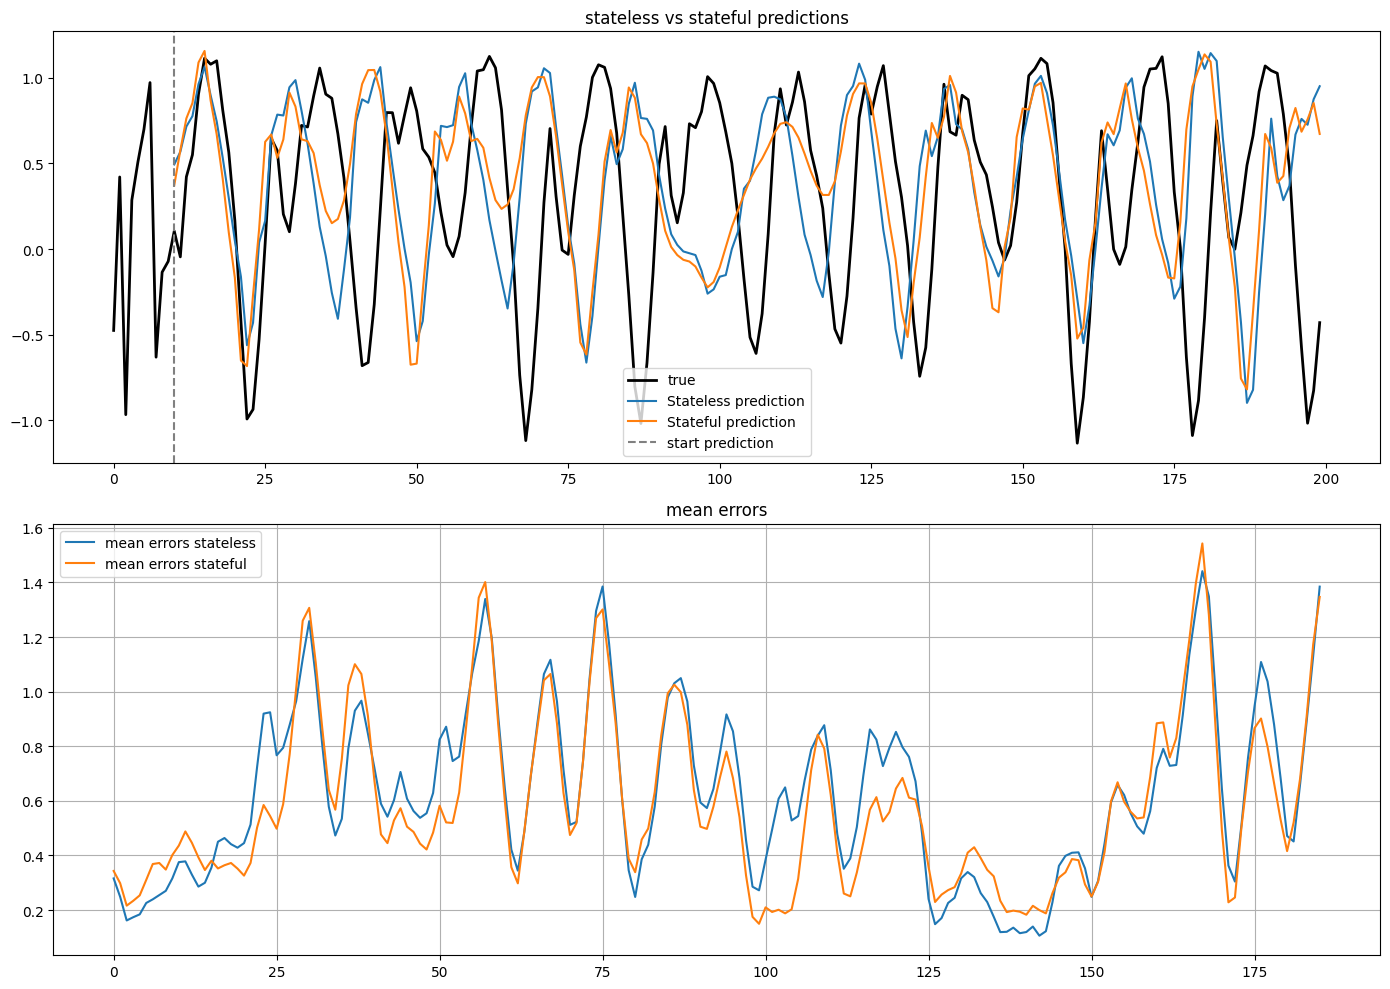

mean error stateless: 0.63603
mean error stateful: 0.59924


In [116]:
stateful_model2 = build_stateful_from_stateless(model2, batch_size=1)
reset_states(stateful_model2)
draw_stateless_vs_stateful(model2, stateful_model2, test_init)

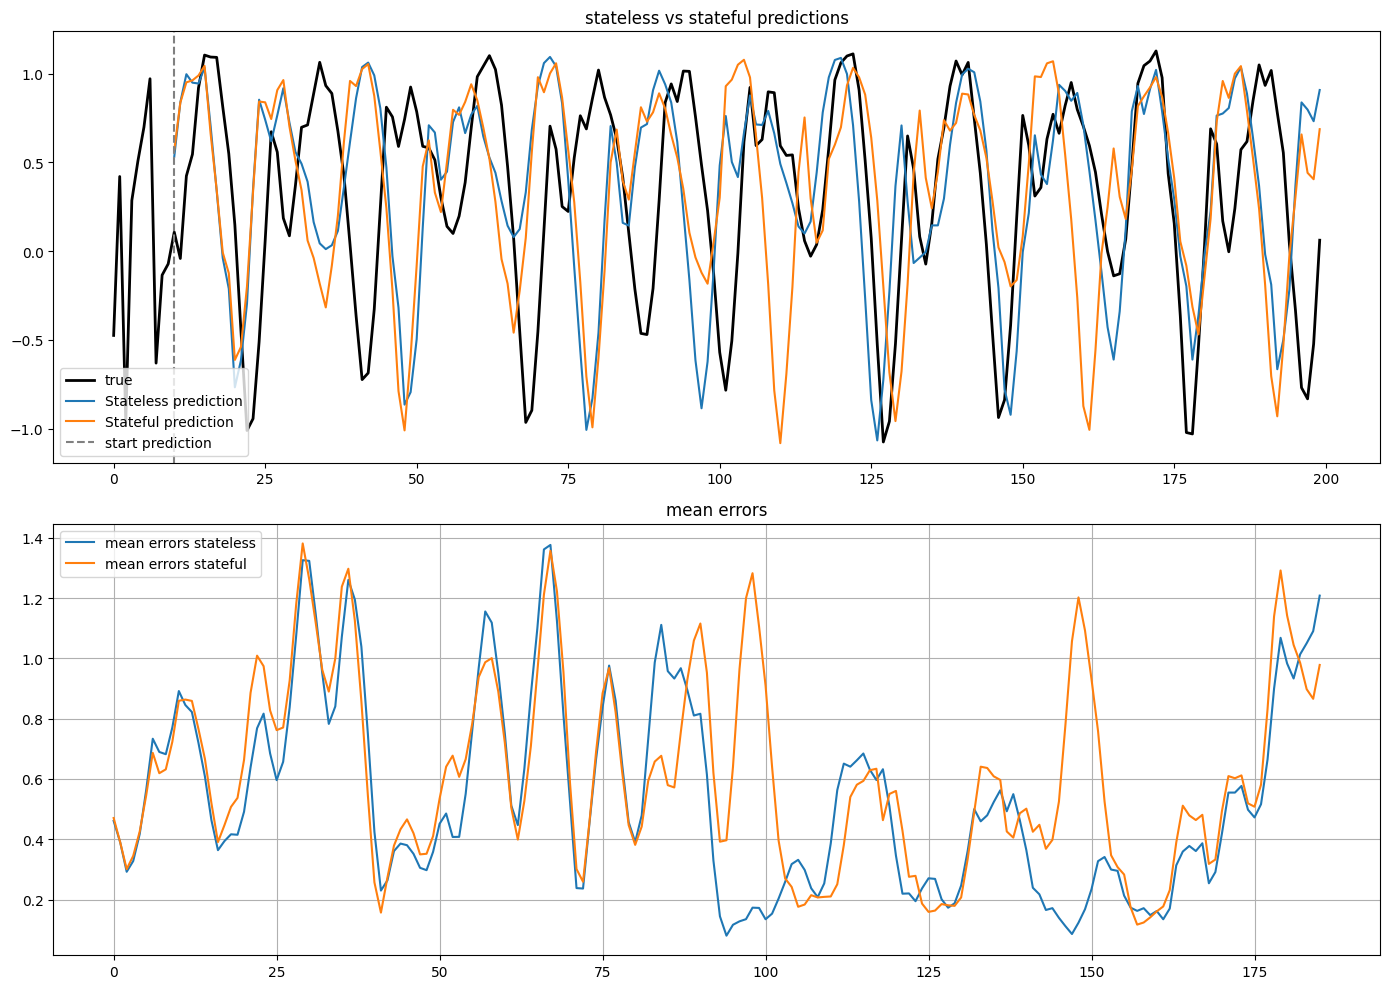

mean error stateless: 0.54931
mean error stateful: 0.62251


In [117]:
stateful_model3 = build_stateful_from_stateless(model3, batch_size=1)
reset_states(stateful_model3)
draw_stateless_vs_stateful(model3, stateful_model3, test_init)

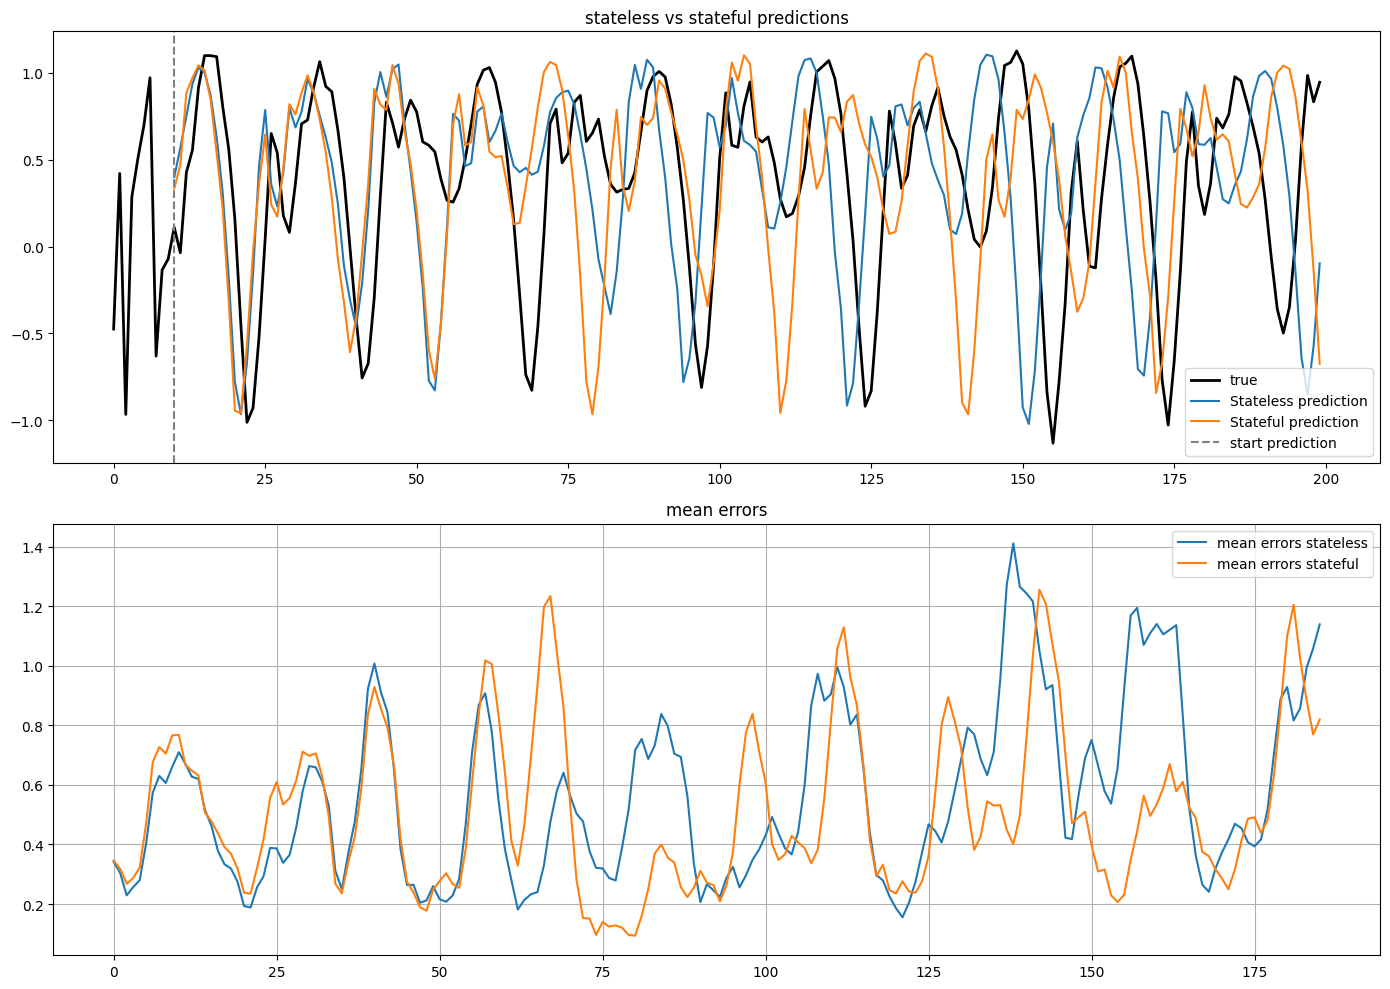

mean error stateless: 0.57225
mean error stateful: 0.51992


In [118]:
stateful_model4 = build_stateful_from_stateless(model4, batch_size=1)
reset_states(stateful_model4)
draw_stateless_vs_stateful(model4, stateful_model4, test_init)